In [28]:
# %env CUDA_VISIBLE_DEVICES=0,1

In [29]:
import os
# Set CUDA devices to GPU 0 and 1
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [31]:
valid_folder_path = "dataset/valid"
valid_csv = pd.read_csv('dataset/valid/_annotations.csv')
valid_csv = valid_csv.rename(columns=({'class':'cls', 'xmin':'x1', 'ymin':'y1', 'xmax':'x2', 'ymax':'y2'}))
valid_csv.head()

,filename,width,height,cls,x1,y1,x2,y2
0,Tr-no_1326_jpg.rf.007af3c784c4ab5ff6ede9ff2426...,442,442,no tumor,64,37,375,410
1,Tr-gl_0086_jpg.rf.021e7950387ef094952e59add5b7...,512,512,giloma,163,191,257,276
2,Tr-gl_0615_jpg.rf.00e096bb27d65dabe85298aea135...,512,512,giloma,284,139,384,256
3,gg-318-_jpg.rf.022454a9b643b0fcb3ba3b59c2e5f22...,512,512,pituitary,229,314,287,352
4,gg-318-_jpg.rf.022454a9b643b0fcb3ba3b59c2e5f22...,512,512,giloma,303,203,393,310


In [32]:
valid_csv.shape, len(valid_csv['filename'].unique())


((682, 8), 607)

In [33]:
def visualize(dataset_csv, temp=0):
    def put_data_on_image(data):
        filename, w, h, cls, x1, y1, x2, y2 = data
        image_path = os.path.join(valid_folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cv2.rectangle(image, (x1,y1), (x2,y2), (255,255,255), 2)
        cv2.putText(image, str(cls), (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        return image
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    for i, ax in enumerate(axes.ravel()):
        image = put_data_on_image(dataset_csv.loc[i+temp])
        ax.axis('off')
        ax.imshow(image, cmap='grey')
    plt.tight_layout()
    plt.show()

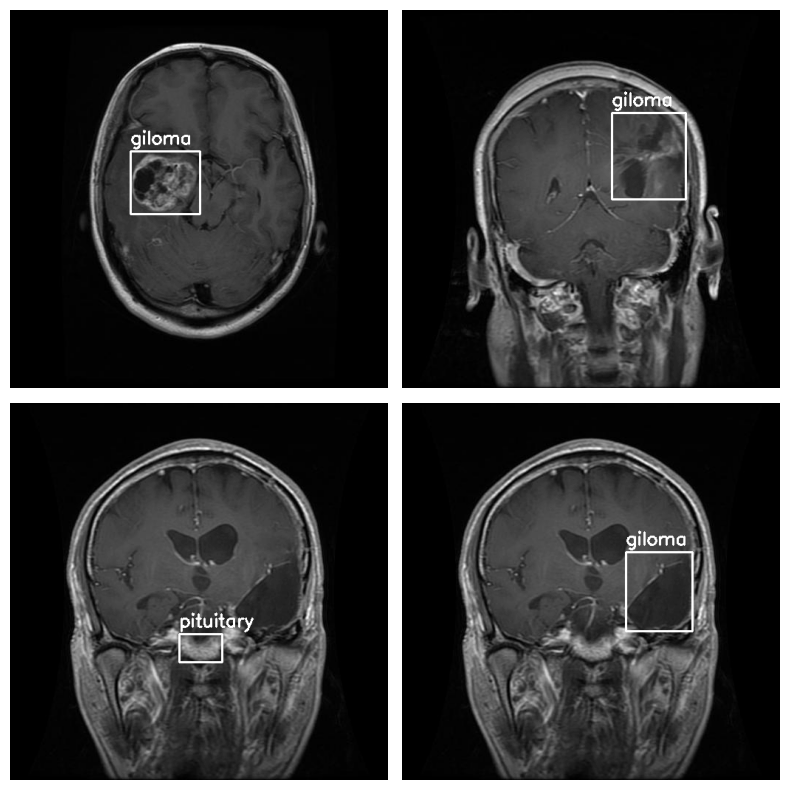

In [34]:
visualize(valid_csv, 1)

In [35]:
label2index = {
    'giloma': 0,
    'meningioma': 1,
    'no tumor': 2,
    'pituitary': 3
}

index2label = {v: k for k, v in label2index.items()}
index2label

{0: 'giloma', 1: 'meningioma', 2: 'no tumor', 3: 'pituitary'}

In [36]:
class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.csv = pd.read_csv(os.path.join(folder_path, '_annotations.csv'))
        self.unique_filenames = self.csv['filename'].unique()

    def __len__(self):
        return len(self.unique_filenames)
    
    def __getitem__(self, idx):
        filename = self.unique_filenames[idx]
        values = self.csv[self.csv.filename == filename]
        boxes = []
        label = []
        for i in range(len(values)):
            filename, w, h, cls, x1, y1, x2, y2 = values.iloc[i]
            boxes.append((x1, y1, x2, y2))
            label.append((label2index[cls]))

        image_path = os.path.join(self.folder_path, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

        # Prepare target
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(label, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return image, target

In [37]:
def custom_collate(data):
    return data

In [38]:
train_ds = CustomDataset(folder_path='dataset/train')
valid_ds = CustomDataset(folder_path='dataset/valid')

train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=custom_collate)
valid_dl = DataLoader(valid_ds, batch_size=2, shuffle=False, collate_fn=custom_collate)

In [39]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [40]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
num_classes = 80
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# model = torch.nn.DataParallel(model, device_ids=[0,1])
model = model.to(device)

/home/mahfuj/miniconda3/envs/yolo/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mahfuj/miniconda3/envs/yolo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

In [42]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision


# Function to calculate mAP, precision, and recall on the validation dataset
def calculate_metrics(model, dataloader, device, iou_thresholds=[0.5, 0.75, 0.95]):
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Calculating mAP'):
            images = [d[0].to(device) for d in data]
            targets = [{'boxes': d[1]['boxes'].to(device), 'labels': d[1]['labels'].to(device)} for d in data]
            
            predictions = model(images)
            
            # Collect targets and predictions for mAP calculation
            all_targets.extend(targets)
            all_predictions.extend(predictions)

    # Calculate mAP@0.5, mAP@0.5-0.95, precision, and recall
    map_50, map_50_90, precision, recall = calculate_map_precision_recall(all_targets, all_predictions, iou_thresholds)
    return map_50, map_50_90, precision, recall

# Function to calculate mAP, precision, and recall on the validation dataset
def calculate_map_precision_recall(targets, predictions, iou_thresholds=[0.5, 0.75, 0.95]):
    # Initialize the MeanAveragePrecision metric
    metric = MeanAveragePrecision(iou_thresholds=iou_thresholds, class_metrics=False)

    # Prepare target and prediction dictionaries for evaluation
    formatted_targets = []
    formatted_predictions = []

    for target in targets:
        formatted_targets.append({
            "boxes": target["boxes"],
            "labels": target["labels"]
        })

    for pred in predictions:
        formatted_predictions.append({
            "boxes": pred["boxes"],
            "labels": pred["labels"],
            "scores": pred["scores"]
        })

    # Update the metric with predictions and targets
    metric.update(formatted_predictions, formatted_targets)

    # Compute metrics
    result = metric.compute()

    # Extract mAP at IoU=0.5, mAP@0.5-0.95, precision, and recall
    map_50 = result['map_50']
    map_50_90 = result['map']
    precision = result['map_per_class_precision']
    recall = result['map_per_class_recall']

    return map_50, map_50_90, precision, recall

In [43]:
# Initialize the history dictionary
history = {
    "train_loss": [],
    "val_loss": [],
    "map_50": [],
    "map_50_90": [],
    "precision": [],
    "recall": []
}

best_map_50 = 0.0  # Track the best mAP@0.5 achieved

for epoch in range(num_epochs):
    epoch_loss = 0
    val_loss = 0

    # Training Loop
    model.train()
    pbar = tqdm(valid_dl, desc=f"Epoch {epoch+1} [Train]", leave=False)
    for data in pbar:
        images = []
        targets = []
        for d in data:
            images.append(d[0].to(device))
            targets.append({
                'boxes': d[1]['boxes'].to(device),
                'labels': d[1]['labels'].to(device),
            })

        # Forward pass
        loss_dict = model(images, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar with current loss
        pbar.set_postfix(loss=loss.cpu().detach().numpy(), )

        break

    # Validation Loop
    model.eval()
    with torch.no_grad():
        val_pbar = tqdm(valid_dl, desc=f"Epoch {epoch+1} [Validation]", leave=False)
        for val_data in val_pbar:
            val_images = []
            val_targets = []
            for d in val_data:
                val_images.append(d[0].to(device))
                val_targets.append({
                    'boxes': d[1]['boxes'].to(device),
                    'labels': d[1]['labels'].to(device),
                })

            # Forward pass
            model.train()
            val_loss_dict = model(val_images, val_targets)
            val_loss_batch = sum(v for v in val_loss_dict.values())
            val_loss += val_loss_batch.cpu().detach().numpy()
            model.eval()


            # Update progress bar with validation loss
            val_pbar.set_postfix(val_loss=val_loss_batch.cpu().detach().numpy())
            
            break

            # Calculate mAP for validation
        map_50, map_50_90, precision, recall = calculate_metrics(model, valid_dl, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, mAP@0.5: {map_50:.4f}, mAP@0.5-0.95: {map_50_90:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

        # Track metrics in history dictionary
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['map_50'].append(map_50)
        history['map_50_90'].append(map_50_90)
        history['precision'].append(precision)
        history['recall'].append(recall)

        # Check if current mAP@0.5 is the best and save the model if it is
        if map_50 > best_map_50:
            best_map_50 = map_50
            best_model_path = os.path.join("models", "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best mAP@0.5: {best_map_50:.4f}. Model saved to {best_model_path}.")

    # Print or access the history after training
    print("Training complete. History:", history)

Epoch 1 [Train]:   0%|          | 0/304 [00:00<?, ?it/s]

Calculating mAP: 100%|██████████| 304/304 [00:42<00:00,  7.19it/s]               


KeyError: 'map_per_class_precision'